In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
from scipy import stats
from IPython.display import Image


# Rare-event simulation
## Lecture 1
### Patrick Laub, Institut de Science Financière et d’Assurances

## Who am I? 

- Patrick (Pat) Laub
- Post-doc here
- Background in Software Engineering and Mathematics
- PhD in Applied Probability between Australia & Denmark
- patrick.laub@gmail.com, office in 1405

## Rare-event estimation

Calculating tiny probabilities using computers...

Classical problem is

$$ \ell = \mathbb{P}(X > \gamma) $$

for $\gamma \gg 0$. E.g. $\ell \in [10^{-4}, 10^{-15}]$. 

Or, related problem, of finding

$$ \mathbb{E}[ X 1\{ X > \gamma \} ] . $$

## Applications 

All kinds of systems reliability problems. Want to control the a nuclear reactor to ensure

$$ \ell = \mathbb{P}(\text{Maximum Temperature over}~T~\text{years} > \gamma) $$

is small. 

## Insurance applications

Writing a contract to cover a country for catastrophic weather conditions. 

Or, in loss distribution approach, have aggregate losses $ S_N = \sum_{i=1}^N X_i $ where the number of claims $N$ is random, as are the claim sizes $X_i$. Want to know

$$ \text{Value-at-Risk}_\alpha = \inf\{ x : \mathbb{P}(S_N < x) \ge 1 - \alpha \} $$

when $\alpha \in (0, 1) $ is small. 

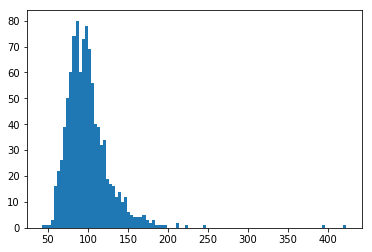

In [29]:
Ns = rnd.poisson(100, size=1000); Xs = rnd.pareto(2, size=np.sum(Ns))
cumNs = np.insert(np.cumsum(Ns), 0, 0)
S_Ns = np.array([np.sum(Xs[cumNs[i]:cumNs[i+1]]) for i in range(R)])
plt.hist(S_Ns, bins=R//10);

### Finance application: out-of-the-money option pricing

Want

$$ \mathbb{E}[ (S_T - K)_+ \mid S_0 ] $$

for stock price $(S_t)_{t \ge 0}$, and $S_0 \ll K$.

For example, $K = 107$, and $S_t = S_0 \cdot \mathrm{e}^{X_t}   $ where $X_t \sim \text{BM}(\mu=0.04, \sigma = 0.01)$, and $S_0 = 100$.

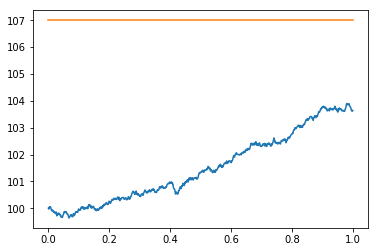

In [13]:
K = 107; r = 0.04; σ = 0.01; S_0 = 100
ts = np.linspace(0, 1, 1000)
dt = ts[1] - ts[0]

jumps = r*dt + σ * np.sqrt(dt) * rnd.normal(size=len(ts)-1)
X_t = np.cumsum(np.insert(jumps, 0, 0))
S_t = S_0 * np.exp(X_t)

plt.plot(ts, S_t)
plt.plot([ts.min(), ts.max()], [K, K])

plt.show()

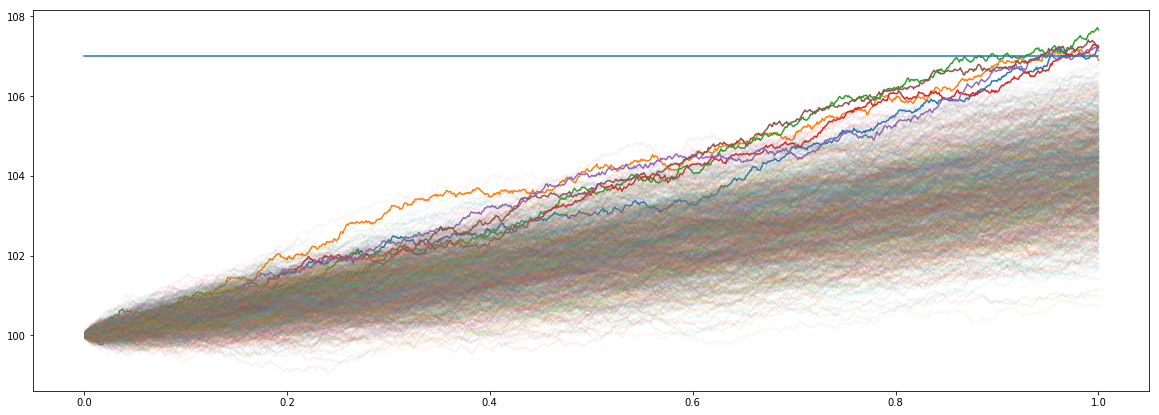

6 out of 1000 in the money


In [19]:
fig, ax = plt.subplots(figsize=(20, 7))

K = 107; r = 0.04; σ = 0.01; S_0 = 100
ts = np.linspace(0, 1, 1000)
dt = ts[1] - ts[0]


R = 1000
norms = rnd.normal(size=[len(ts)-1, R])
jumps = r*dt + σ*np.sqrt(dt) * norms
X_t = np.cumsum(jumps, axis=0)
S_t = S_0 * np.exp(X_t)


winners = (S_t.max(axis=0) > K)

if sum(winners) > 0:
    plt.plot(ts[1:], S_t[:,winners])
losers = ~winners
plt.plot(ts[1:], S_t[:,losers], alpha=0.08)

#plt.plot(ts[1:], S_t)

plt.plot([ts.min(), ts.max()], [K, K])
plt.show()

print("{} out of {} in the money".format(sum(winners), R))

### Finance application: barrier option pricing

Want

$$ \mathbb{E}[ (S_T - K)_+ 1 \{ \min_{t \in [0,T]} S_t < \gamma \} \mid S_0 ] $$

for stock price $(S_t)_{t \ge 0}$, and $\gamma \ll S_0 \ll K$.

For example, $K = 110$, $\gamma = 99$, and $S_t = S_0 \cdot \mathrm{e}^{X_t}   $ where $X_t \sim \text{BM}(\mu=0.04, \sigma = 0.04)$, and $S_0 = 100$.

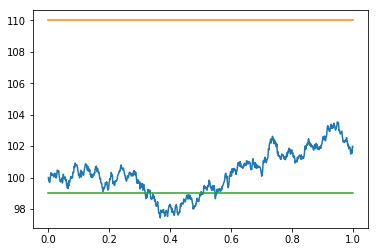

In [5]:
K = 110; γ = 99; r = 0.04; σ = 0.04; S_0 = 100
ts = np.linspace(0, 1, 1000)
dt = ts[1] - ts[0]

jumps = r*dt + σ * np.sqrt(dt) * rnd.normal(size=len(ts)-1)
X_t = np.cumsum(np.insert(jumps, 0, 0))
S_t = S_0 * np.exp(X_t)

plt.plot(ts, S_t)
plt.plot([ts.min(), ts.max()], [K, K])
plt.plot([ts.min(), ts.max()], [γ, γ])

plt.show()

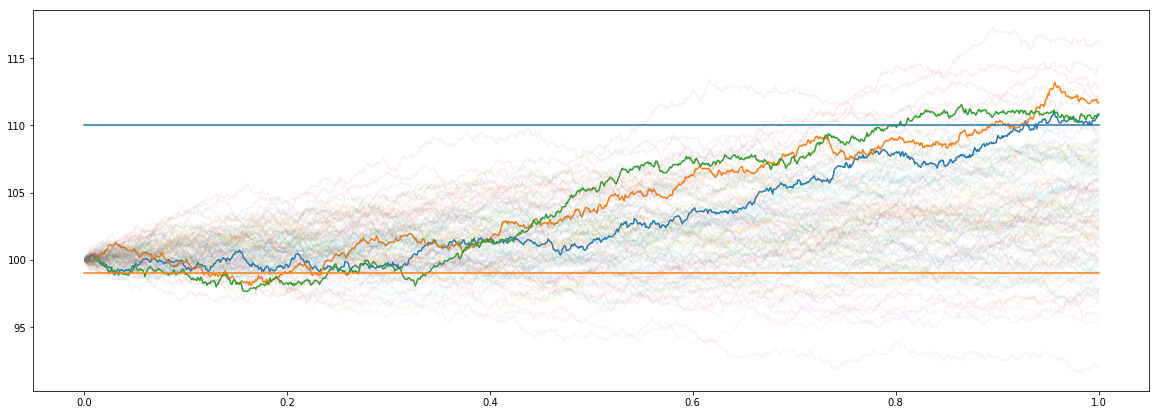

3 out of 100 in the money


In [50]:
K = 110; γ = 99; r = 0.04; σ = 0.04; S_0 = 100; R = 100
ts = np.linspace(0, 1, 1000)
dt = ts[1] - ts[0]

fig, ax = plt.subplots(figsize=(20, 7))


norms = rnd.normal(size=[len(ts)-1, R])
jumps = r*dt + σ*np.sqrt(dt) * norms
X_t = np.cumsum(jumps, axis=0)
S_t = S_0 * np.exp(X_t)

winners = (S_t.min(axis=0) < γ) * (S_t.max(axis=0) > K)

if sum(winners) > 0:
    plt.plot(ts[1:], S_t[:,winners])
losers = ~winners
plt.plot(ts[1:], S_t[:,losers], alpha=0.08)

plt.plot([ts.min(), ts.max()], [K, K], alpha=1)
plt.plot([ts.min(), ts.max()], [γ, γ])
plt.show()

print("{} out of {} in the money".format(sum(winners), R))

## To model, or not to model: that is the question

__Data $\rightarrow$ Model $\rightarrow$ Results__

versus

__Data $\longrightarrow$ Results__

$$ \mathbb{P}(\text{Event}) \approx \text{ Historical frequency of the event}  $$

If a 'black swan', then you'd say $\mathbb{P}(\text{Event}) = 0$.

## First option: do the math

If the distribution is simple, we can do some algebra to get the answer:

$$ \ell = \mathbb{P}(X > \gamma) \qquad X \sim \mathrm{Pareto}(\alpha) $$

$$ \ell = \int_\gamma^\infty f_X(x) \, \mathrm{d}x = \int_\gamma^\infty \frac{\alpha}{x^{\alpha+1}} \mathrm{d}x 
= \Bigl[ - \frac{1}{x^{\alpha}} \Bigr]_\gamma^\infty = \frac{1}{\gamma^\alpha} $$

Here, doesn't matter if $\gamma \gg 0$.



## Second option: approximate the integral

If algebra fails, can write the problem as an integral, and approximate that.

$$ \ell = \mathbb{P}(X_1 + X_2 > \gamma) \qquad X_i \overset{\mathrm{i.i.d.}}{\sim} \mathrm{Pareto}(\alpha) $$

$$ \ell = \int_{x_1 = 1}^\infty \int_{x_2 = 1}^\infty 1\{x_1 + x_2 > \gamma\}  f_{X_1}(x_1) f_{X_2}(x_2) \,\mathrm{d} x_1 \, \mathrm{d} x_2 $$


All numerical integrations look like

$$ \int f(x) \,\mathrm{d} x \approx \sum_{i=1}^N w_i f(x_i) $$


#### Mid-point Riemann rule 

$$ \int_a^b f(x) \,\mathrm{d} x \approx \sum_{i=1}^{n-1} f\left( \frac{x_i + x_{i+1}}{2} \right) h \,. $$

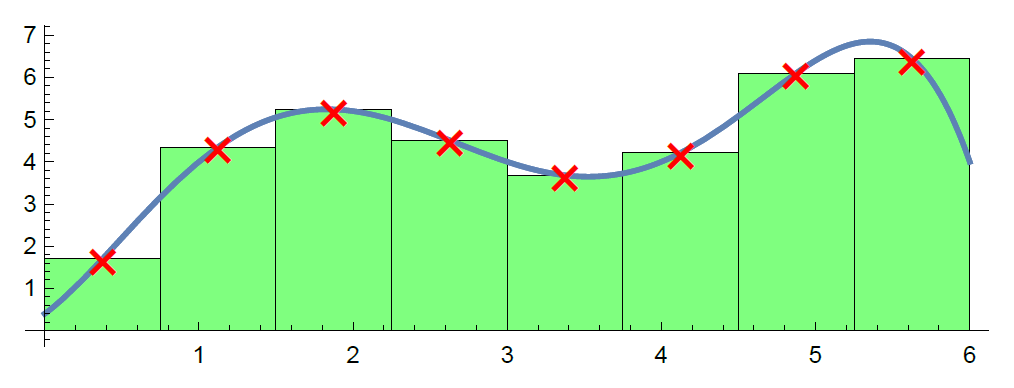

In [3]:
Image("riemann.png")

#### Trapezoidal rule approximation

$$ \int_a^b f(x) \,\mathrm{d} x \approx \sum_{i=1}^{n-1} \frac{ f(x_i) + f(x_{i+1}) }{2} h \,. $$

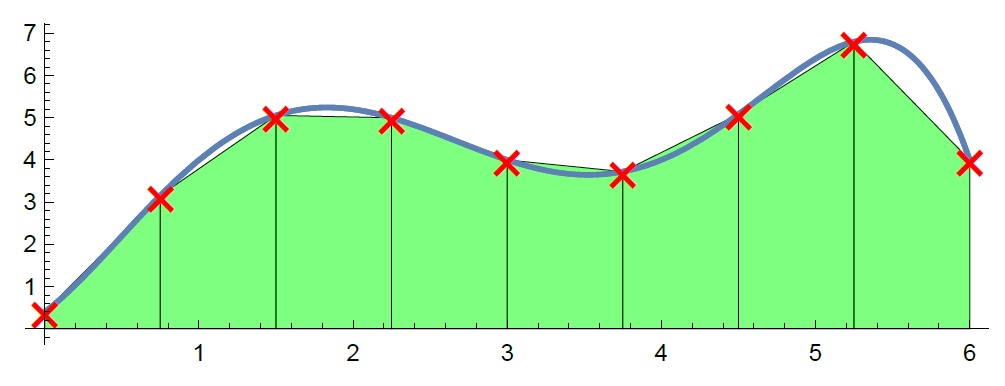

In [4]:
Image("trapezoidal.png")

#### Simpson's rule approximation

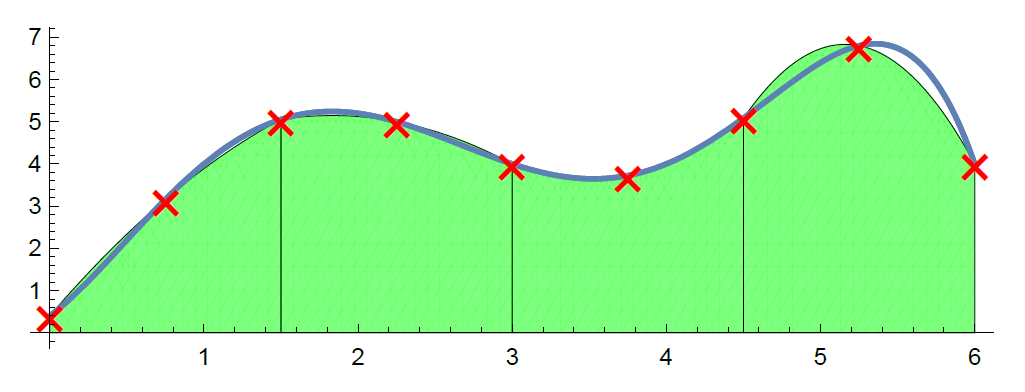

In [5]:
Image("simpson.png")

Go from here up to the Newton-Cotes rules...

### Numerical integration

In one dimension we evaluate the function $N$ times.

$$ \int f(x) \,\mathrm{d} x \approx \sum_{i=1}^N w_i f(x_i) $$

How does it extend to multiple dimensions?

$$ \int \int f(x, y) \,\mathrm{d} x \, \mathrm{d} y \approx \sum_{i=1}^N \sum_{j=1}^N w_i w_j f(x_i, y_j) $$

Now it is evaluated $N^2$ times. __Problem!__ For a problem with dimension $d$: 

$$ \text{Number of function evaluations needed for fixed error} = \text{Constant}^d $$ 

__Conclusion:__ for $d > 5$ give up hope \[Also, no simple error bounds\]

## Option 3: use "integration by darts" Monte Carlo

Say that we want to estimate $\ell = \mathbb{P}(X > \gamma)$ for $X \sim F_X$ with a _crude Monte Carlo estimate_

$$ \hat{\ell} = \frac{1}{R} \sum_{r=1}^R 1\{X_r > \gamma\} \,, \qquad X_r \overset{\mathrm{i.i.d.}}{\sim} F_X \,.$$

Then we have $\mathbb{E}[ \hat{\ell} ] = \ell$, i.e., it is _unbiased_.

### Example: estimating $\pi$ 

Take $X, Y \overset{\mathrm{i.i.d.}}{\sim} \mathsf{Uniform}(0,1)$, and consider $\ell = \mathbb{P}( || (X,Y) ||_2 \le 1 ) = \mathbb{P}( X^2 + Y^2 \le 1 )$.

We can estimate it by 
$$ \hat{\ell} = \frac1R \sum_{r=1}^R 1 \{ X_r^2 + Y_r^2 \le 1\} \,. $$ 

Can also use a bit of logic to figure out that 

$$ \ell = \frac{\text{Area of a quadrant of the unit circle}}{\text{Area of the } [0,1]^2 \text{ square}} = \frac{\pi}{4} .$$

So, 
$$ \hat{\ell} \approx \ell = \frac{\pi}{4} \quad \Leftrightarrow \quad \pi \approx 4 \cdot \hat{\ell} .$$


#### Results:


In [36]:
import numpy as np
from scipy import stats

R = 10**6
Us = stats.uniform.rvs(size=(R, 2))
norms = np.linalg.norm(Us, axis=1)
indicators = norms < 1
ests = 4 * indicators

ellHat = ests.mean()
sigmaHat = ests.std()
print(ellHat)

3.138568


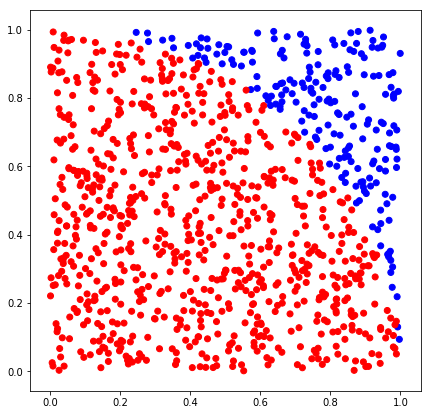

In [41]:
import matplotlib.pyplot as plt

numToPlot = 10**3
colors = ['r' if ind else 'b' 
          for ind in indicators[:numToPlot]]

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(Us[:numToPlot,0], Us[:numToPlot,1], color=colors)
plt.show()

In [88]:
for Rexp in range(1, 6 + 1):
    ellHatMini = ests[:10**Rexp].mean()
    widthCI = 1.96 * sigmaHat / np.sqrt(10**Rexp)
    lowerCI = ellHatMini - widthCI
    upperCI = ellHatMini + widthCI
    
    print("R = 10^{}, \t Est = {:10}, \t Est_ = {}, \t Est^+ = {}".format(Rexp, ellHatMini, lowerCI, upperCI))

R = 10^1, 	 Est =        3.2, 	 Est_ = 2.182251830880273, 	 Est^+ = 4.217748169119727
R = 10^2, 	 Est =        3.4, 	 Est_ = 3.0781597701115415, 	 Est^+ = 3.7218402298884583
R = 10^3, 	 Est =      3.136, 	 Est_ = 3.0342251830880276, 	 Est^+ = 3.2377748169119727
R = 10^4, 	 Est =     3.1424, 	 Est_ = 3.110215977011154, 	 Est^+ = 3.174584022988846
R = 10^5, 	 Est =    3.14296, 	 Est_ = 3.1327825183088027, 	 Est^+ = 3.1531374816911972
R = 10^6, 	 Est =   3.141796, 	 Est_ = 3.1385775977011154, 	 Est^+ = 3.145014402298884



| $R$                | $10^1$ | $10^2$ | $10^3$ | $10^4$ |  $10^5$ | $10^6$ | $10^7$ | $10^8$ | $10^9$ |
| ---                | ---    | ---    | ---    | ---    | ---     | ---    | ---    | ---    | ---    |
|# Digits Confident  | 0      | 0      | 0      | 2      | 2       | 2      | 3      | 4      | 4      |


### Confidence intervals

$$ \hat{\ell}- q_{\alpha/2} \frac{\sigma}{\sqrt{R}} \le \ell \le \hat{\ell}+ q_{\alpha/2}\frac{\sigma}{\sqrt{R}}  \quad \text{with probability } 1-\alpha , $$

where $q_{\alpha/2}$ is the quantile $\mathbb{P}(Z \le q_{\alpha/2}) = \frac{\alpha}{2}$ of $Z \sim \mathsf{Normal}(0,1)$, and $\sigma^2 = \mathbb{V}\mathrm{ar}( 1\{ X > \gamma \} ) = \mathbb{V}\mathrm{ar}( \hat{\ell}(1) ) .$ 

For $\alpha = 0.05$, we have $q_{\alpha/2} \approx 1.96$

Why? Because we can use CLT for $R\to\infty$:

$$ \sqrt{R} \bigl( \hat{\ell}(R) - \ell \bigr) \overset{\mathcal{D}}{\longrightarrow} \mathsf{Normal}(0, \sigma^2) $$
$$ \Rightarrow \hat{\ell}(R) \overset{\mathrm{approx.}}{\sim} \mathsf{Normal}\bigl(\ell, \frac{\sigma^2}{R}\bigr) .$$


### Conclusions to make about the CMC confidence intervals

Great news, it performs the same regardless of dimension!

Terrible news, it takes a bazillion samples to make it accurate.

## CMC is particularly bad in rare-event land

Consider relative-error $|\hat{\ell} - \ell | / \ell  = \sqrt{ (\hat{\ell} - \ell)^2 } / \ell$

$$ \mathrm{RelativeError} = \sqrt{ \mathbb{E} \bigl[ \bigl( \frac{ \hat{\ell} - \ell }{\ell} \bigr)^2 \bigr] }
= \sqrt{  \frac{ \mathbb{V}\mathrm{ar} [\hat{\ell}] }{ \ell^2 } } . $$

Since $R \cdot \hat{\ell}(R) \sim \mathsf{Binomial}(R, \ell)$, we know $\mathbb{V}\mathrm{ar} [ R \cdot \hat{\ell}(R) ] = R \ell (1 - \ell)$, so

$$ \Rightarrow \mathrm{RelativeError} = \sqrt{ \frac{ (1 - \ell) }{ R \ell } } \approx  \sqrt{ \frac{1}{ R \ell } } .$$

As $\ell \searrow 0$ this $\nearrow \infty$. E.g. if $\ell \approx 10^{-6}$, and we want a RE of $0.01$, need $R \approx 10^{10}$.

## Importance sampling

For $X \sim f(\cdot)$, 
$$ \mathbb{P}(X > \gamma) = \mathbb{E}_f[ 1\{ X > \gamma\} ] \approx \frac{1}{R} \sum_{r=1}^R 1\{ X_r > \gamma\} =: \hat{\ell}_{\mathrm{CMC}} $$
where $X_r \overset{\mathrm{i.i.d.}}{\sim} f(\cdot).$ For another density $g(\cdot)$, called the _IS proposal density_,

$$ \mathbb{P}(X > \gamma) = \int_{-\infty}^{\infty} 1\{ x > \gamma\} f(x) \frac{g(x)}{g(x)} \,\mathrm{d}x = \int_{-\infty}^{\infty} 1\{ x > \gamma\} \frac{f(x)}{g(x)} g(x) \,\mathrm{d}x $$

$$ \Rightarrow \mathbb{P}(X > \gamma) 
= \mathbb{E}_g \bigl[ 1\{ X > \gamma\} \frac{f(X)}{g(X)} \bigr] \approx \frac{1}{R} \sum_{r=1}^R 1\{ X_r > \gamma\} \frac{f(X_r)}{g(X_r)}  =: \hat{\ell}_{\mathrm{IS}} $$

where $X_r \overset{\mathrm{i.i.d.}}{\sim} g(\cdot).$

__Technical note__ Make sure $g(x) > 0$ whenever $1 \{ x > \gamma \}$, otherwise we have a division by zero.

### Importance sampling, mixed results


$$ \text{Know } ~~\mathbb{E}[ \hat{\ell}_{\mathrm{IS}} ] = \mathbb{E} [ \hat{\ell}_{\mathrm{CMC}} ] \quad \text{ and want } \quad 
\mathbb{V}\mathrm{ar}[ \hat{\ell}_{\mathrm{IS}} ] < \mathbb{V}\mathrm{ar}[  \hat{\ell}_{\mathrm{CMC}} ] .$$

Example: want $\mathbb{P}( \max\{X_1, X_2\} > 10)$ when $\boldsymbol{X} \sim \mathsf{Normal}([0,0], [1,\rho;\rho,1])$ with $\rho = \mathbb{C}\mathrm{or}(X_1, X_2) = 0.8$.

Use IS for various $\mathsf{Normal}(\mu, 1)$ proposals. 

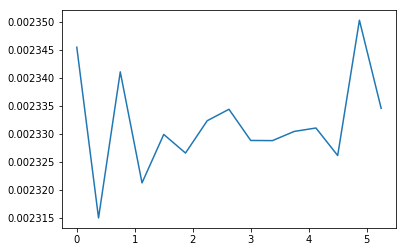

In [36]:
plt.plot(mus, estMeans);

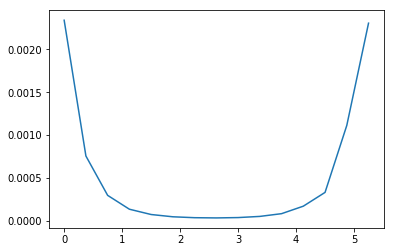

In [37]:
plt.plot(mus, estVars);

## Optimal IS proposal density

What is the optimal IS density for $\ell = \mathbb{P}(X > \gamma)$ for $X \sim f(\cdot)$?

$$ g^*(x) \propto 1\{ x > \gamma \} f(x) $$

$$ g^*(x) = \frac{1\{ x > \gamma \} f(x)}{\ell}  $$

Unbiased and _zero variance_ estimator
$$ \hat{\ell}_{\mathrm{IS}} = 1\{ X_1 > \gamma\} \frac{f(X_1)}{g^*(X_1)} \quad \text{where } X_1 \sim g^* $$
and simplifying
$$ \hat{\ell}_{\mathrm{IS}} = 1\{ X_1 > \gamma\} \frac{f(X_1)}{\frac{1\{ X_1 > \gamma \} f(X_1)}{\ell}} = \ell $$
which is a constant so $\mathbb{V}\mathrm{ar}[ \hat{\ell}_{\mathrm{IS}} ] = 0$.

## Parametric variance minimization problem

Search inside a family of distributions $f( \,\cdot\,  ; \boldsymbol{\theta})$ to find the lowest variance IS proposal.
 
 $$ 
   \DeclareMathOperator*{\argmin}{arg\,min}
  \DeclareMathOperator*{\argmax}{arg\,max}
 \begin{aligned}
 \boldsymbol{v}^* 
 &= \argmin_{\boldsymbol{v}} \mathbb{V}\mathrm{ar}_{f( \,\cdot\,  ; \boldsymbol{v})} \bigl[\hat{\ell}_{\mathrm{IS} }  \bigr] \\
 &= \argmin_{\boldsymbol{v}}\mathbb{V}\mathrm{ar}_{f( \,\cdot\,  ; \boldsymbol{v})}\bigl[ 1\{ X > \gamma\} \frac{f(X)}{f( X ; \boldsymbol{v})}   \bigr] \\
 &= \argmin_{\boldsymbol{v}}\mathbb{E}_{f( \,\cdot\,  ; \boldsymbol{v})} \bigl[ 1\{ X > \gamma\}^2 \frac{f(X)^2}{f( X ; \boldsymbol{v})^2} \bigr] 
   - \mathbb{E}_{f( \,\cdot\,  ; \boldsymbol{v})} \bigl[ 1\{ X > \gamma\} \frac{f(X)}{f( X ; \boldsymbol{v})} \bigr]^2 \\
 &= \argmin_{\boldsymbol{v}} \mathbb{E}_{f( \,\cdot\,  ; \boldsymbol{v})} \bigl[ 1\{ X > \gamma\} \frac{f(X)^2}{f( X ; \boldsymbol{v})^2} \bigr] 
   - \ell^2 \\
 &= \argmin_{\boldsymbol{v}} \mathbb{E}_{f( \,\cdot\,  ; \boldsymbol{v})} \bigl[ 1\{ X > \gamma\} \frac{f(X)^2}{f( X ; \boldsymbol{v})^2} \bigr] = \argmin_{\boldsymbol{v}} \mathbb{E}_{f} \bigl[ 1\{ X > \gamma\} \frac{f(X)}{f( X ; \boldsymbol{v})} \bigr] .
\end{aligned}
 $$
 

## Parametric variance minimization problem continued

Search inside a family of distributions $f( \,\cdot\,  ; \boldsymbol{\theta})$ to find the lowest variance IS proposal.
 
 $$ 
    \DeclareMathOperator*{\argmin}{arg\,min}
  \DeclareMathOperator*{\argmax}{arg\,max}
 \boldsymbol{v}^* 
 = \argmin_{\boldsymbol{v}} \mathbb{E}_{f} \bigl[ 1\{ X > \gamma\} \frac{f(X)}{f( X ; \boldsymbol{v})} \bigr]
 \approx \argmin_{\boldsymbol{v}} \frac{1}{R} \sum_{r=1}^R 1\{ X_r > \gamma\} \frac{f(X_r)}{f( X_r ; \boldsymbol{v})}
 $$
 
 where $X_r \overset{\mathrm{i.i.d.}}{\sim} f$. Need to solve this numerically, either with _numerical optimisation_ or by _rootfinding_:
 
 $$ \nabla_{\boldsymbol{v}} \Bigl\{ \frac{1}{R} \sum_{r=1}^R 1\{ X_r > \gamma\} \frac{f(X_r)}{f( X_r ; \boldsymbol{v})} \Bigr\}
  = \frac{1}{R} \sum_{r=1}^R 1\{ X_r > \gamma\} f(X_r) \, \nabla_{\boldsymbol{v}} \Bigl\{ \frac{1}{f( X_r ; \boldsymbol{v})} \Bigr\} = \boldsymbol{0} .$$
  
  
As $\nabla_{\boldsymbol{v}} \frac{1}{f( X_r ; \boldsymbol{v})} = - \frac{1}{f( X_r ; \boldsymbol{v})^2} \nabla_{\boldsymbol{v}} \, f( X_r; \boldsymbol{v}) = - \frac{1}{f( X_r ; \boldsymbol{v})} \nabla_{\boldsymbol{v}} \log\bigl( f( X_r; \boldsymbol{v}) \bigr) $ which is the _score function_, so

$$ 
\sum_{r=1}^R 1\{ X_r > \gamma\}  \frac{f(X_r)}{f( X_r ; \boldsymbol{v})} \nabla_{\boldsymbol{v}} \log\bigl( f( X_r; \boldsymbol{v}) \bigr)  = \boldsymbol{0} . $$

## Parametric variance minimization problem for rare events

Search inside a family of distributions $f( \,\cdot\,  ; \boldsymbol{\theta})$ to find the lowest variance IS proposal. Solving:

 $$ 
    \DeclareMathOperator*{\argmin}{arg\,min}
  \DeclareMathOperator*{\argmax}{arg\,max}
\argmin_{\boldsymbol{v}} \frac{1}{R} \sum_{r=1}^R 1\{ X_r > \gamma\} \frac{f(X_r)}{f( X_r ; \boldsymbol{v})} 
 $$
 
 where $X_r \overset{\mathrm{i.i.d.}}{\sim} f$. These $1\{ X_r > \gamma\}$ will all be zero if $\gamma \gg 0$. 
 
 Could do some importance sampling with proposal $f( \,\cdot\, ; \boldsymbol{w})$:
 
 
 $$
 \begin{aligned}
 \boldsymbol{v}^* 
 &= \argmin_{\boldsymbol{v}} \mathbb{E}_{f} \bigl[ 1\{ X > \gamma\} \frac{f(X)}{f( X ; \boldsymbol{v})} \bigr] 
 = \argmin_{\boldsymbol{v}} \mathbb{E}_{ f( \,\cdot\, ; \boldsymbol{w}) } \bigl[ 1\{ X > \gamma\} \frac{f(X)}{f( X ; \boldsymbol{v})}  \frac{f(X)}{f( X ; \boldsymbol{w})} \bigr] \\
 &\approx \argmin_{\boldsymbol{v}} \frac{1}{R} \sum_{r=1}^R 1\{ X_r > \gamma\} \frac{f(X_r)}{f( X_r ; \boldsymbol{v})} \frac{f(X_r)}{f( X_r ; \boldsymbol{w})}
 \end{aligned}
 $$
 
where $X_r \overset{\mathrm{i.i.d.}}{\sim} f( \,\cdot\, ; \boldsymbol{w})$.

 ## Cross-entropy method
 
__Iteratively__ finds better importance sampling distributions, by minimising the distance between the current guess to the __optimal IS distribution__.

Example: find $\mathbb{P}(Z > 5)$ for $Z \sim \mathsf{Normal}(0, 1)$, using IS with proposal distributions which are $\mathsf{Normal}(\mu, \sigma^2)$.

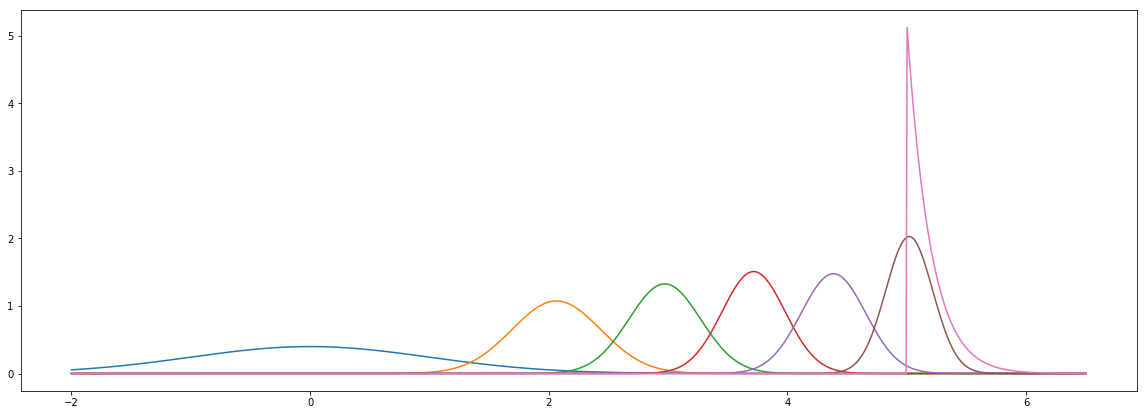

In [30]:
fig, ax = plt.subplots(figsize=(20, 7))

xs = np.linspace(-2, 6.5, 1000)
ys = [dist.pdf(xs) for dist in propDistHistory]
ys.append( origDist.pdf(xs) * (xs > γ) / (1 - origDist.cdf(γ)) )

ax.plot(xs, np.array(ys).T);
#plt.ylim([0,5]);

 ## Cross-entropy method: high level
 
 
 1. Choose a family of distributions to search inside for the best IS proposal, $f( \,\cdot\,  ; \boldsymbol{\theta})$.
 2. Choose some distribution in the family as the starting point, $f( \,\cdot\, ; \boldsymbol{v}_{\ 0})$.
 3. Iteratively construct a better proposal $\boldsymbol{v}_i$ based on the previous $\boldsymbol{v}_{i-1}$ by stepping closer to the optimal $g^*$.
 4. When this converges to some $\boldsymbol{v}_*$, return the result of IS with $f( \,\cdot\, ; \boldsymbol{v}_*)$ proposal.

 ## Cross-entropy method: some more details
 
 1. Choose a family $f( \,\cdot\, ; \boldsymbol{\theta})$, a starting point $\boldsymbol{v}_{\ 0}$, $R$ (e.g. $R=10^6$), and $\rho$ (e.g. $\rho = 0.10$). 
 2. For $i=1,2,\dots$:
     1. Simulate $X_r \overset{\mathrm{i.i.d.}}{\sim} f( \,\cdot\, ; \boldsymbol{v}_{i-1})$ for $r=1,\dots,R$.
     2. Find the quantile $\gamma_i = \mathrm{Quantile}( \{ X_1, \dots, X_R\} , 1-\rho)$.
     3. If $\gamma_i \ge \gamma$, set $\boldsymbol{v}_* = \boldsymbol{v}_{i-1}$, and quit the loop.
     3. Create the _elite set_, $\mathcal{E} = \{ X_r : X_r \ge \gamma_i \}$.
     4. Choose the next $\boldsymbol{v}_{i}$ to be the weighted MLE of the elites $\mathcal{E}$ where the weights are
     $w_r = \frac{f(X_r)}{ f(X_r; \boldsymbol{v}_{i-1}) }$.
 3. Return the result of IS with $f( \,\cdot\, ; \boldsymbol{v}_*)$ proposal.

 ## Cross-entropy method: with all the gory details
  
 1. Choose a family $f( \,\cdot\, ; \boldsymbol{\theta})$, a starting point $\boldsymbol{v}_{\ 0}$, $R$ (e.g. $R=10^6$), and $\rho$ (e.g. $\rho = 0.10$).
 2. For $i=1, 2, \dots$:
     1. Simulate $X_r \overset{\mathrm{i.i.d.}}{\sim} f( \,\cdot\, ; \boldsymbol{v}_{i-1})$  for $r=1,\dots,R$.
     2. Find the quantile $\gamma_i = \mathrm{Quantile}( \{ X_1, \dots, X_R\} , 1-\rho)$.
     3. If $\gamma_i \ge \gamma$, set $\boldsymbol{v}_* = \boldsymbol{v}_{i-1}$, and quit the loop.
     3. Set
     $$
     \DeclareMathOperator*{\argmax}{arg\,max}
     \boldsymbol{v}_{i} = \argmax_{\boldsymbol{v}} \frac{1}{R} \sum_{r=1}^R 1\{ X_r > \gamma_i \} \frac{f(X_r)}{f(X_r; \boldsymbol{v}_{i-1})} \log \bigl[ f(X_r; \boldsymbol{v}) \bigr]
     $$
     by letting $\boldsymbol{v}_{i}$ be the solution to
     $$ \sum_{r=1}^R 1\{ X_r > \gamma_i \} \frac{f(X_r)}{f(X_r; \boldsymbol{v}_{i-1})} \nabla_{\hspace{-5px}\boldsymbol{v}} \Bigl\{ \log \bigl[ f(X_r; \boldsymbol{v}) \bigr] \Bigr\} = \boldsymbol{0} .$$
 3. Return the result of IS with $f( \,\cdot\, ; \boldsymbol{v}_*)$ proposal.

### Worked example: Exponential distributions

Example, $f(x ; \theta) = \frac{1}{\theta} \mathrm{e}^{-\frac{x}{\theta}}$, i.e., $f( \,\cdot\, ; \theta)$ is $\mathsf{Exponential}(\frac{1}{\theta})$.

Say that we've simulated $X_r \overset{\mathrm{i.i.d.}}{\sim} f( \,\cdot\, ; v_{i-1})$ for $r=1,\dots,R$.
Want to find $v_i$ be the solution to

$$ \sum_{r=1}^R 1\{ X_r > \gamma_i \} \frac{f(X_r)}{f(X_r; v_{i-1})} \frac{\mathrm{d}}{\mathrm{d} v} \Bigl\{ \log \bigl[ f(X_r; v) \bigr] \Bigr\} = 0 .$$


$$ 
\frac{\mathrm{d}}{\mathrm{d} v} \Bigl\{ \log \bigl[ \frac{1}{v} \mathrm{e}^{-\frac{X_r}{v}} \bigr] \Bigr\} 
= \frac{\mathrm{d}}{\mathrm{d} v} \Bigl\{ \log [ v^{-1} ] - X_r v^{-1}  \Bigr\} 
=  -v v^{-2}  + X_r v^{-2}
= \frac{X_r}{v^2} -\frac{1}{v} .
$$

Problem to solve is then

$$ \sum_{r=1}^R 1\{ X_r > \gamma\} \frac{f(X_r)}{f(X_r; v_{i-1})} \bigl( \frac{X_r}{v_i^2} -\frac{1}{v_i}  \bigr) = 0
$$

$$ \frac{1}{v_i} \sum_{r=1}^R 1\{ X_r > \gamma\} \frac{f(X_r)}{f(X_r; v_{i-1})}
= \frac{1}{v_i^2} \sum_{r=1}^R 1\{ X_r > \gamma\} \frac{f(X_r)}{f(X_r; v_{i-1})} X_r
$$

$$ v_i
= \frac{ \sum_{r=1}^R 1\{ X_r > \gamma\} \frac{f(X_r)}{f(X_r; v_{i-1})} X_r }{ \sum_{r=1}^R 1\{ X_r > \gamma\} \frac{f(X_r)}{f(X_r; v_{i-1})}} .
$$

Remember, the MLE estimate for the mean of an exponential distribution is

$$ \hat{\mu} = \frac{1}{R} \sum_{r=1}^R X_r  \quad \Rightarrow \quad \hat{\mu}_w = \frac{ \sum_{r=1}^R w_r X_r }{ \sum_{r=1}^R w_r } . $$

